Notes: 
 - consistent colors for all methods
 - bold or somehow distinguish the `random` and `oracle` methods

In [11]:
library(tidyverse)
library(RColorBrewer)
library(stringr)

In [3]:
results = bind_rows(
    read_csv("data/experimental_results.csv"), 
    read_csv("data/experimental_results_2.csv"))

Parsed with column specification:
cols(
  model = col_character(),
  selection_method = col_character(),
  true_hte_error = col_double(),
  true_value = col_double(),
  DGP = col_character(),
  n_train = col_double(),
  n_test = col_double(),
  n_folds = col_integer(),
  rep = col_integer()
)
Parsed with column specification:
cols(
  model = col_character(),
  selection_method = col_character(),
  true_hte_error = col_double(),
  true_value = col_double(),
  DGP = col_character(),
  n_train = col_double(),
  n_test = col_double(),
  n_folds = col_integer(),
  rep = col_integer()
)


In [125]:
rel_tmse = function(error, method) {
    return(error/(error[method=="oracle_selector_true_hte_error"]))
}

rel_cost = function(error, method) {
    return((error - error[method=="oracle"])/(error[method=="oracle_selector_true_value"] - error[method=="oracle"]))
}

In [66]:
all_methods = results %>% pull(selection_method) %>% unique
method_types = list(
    framework_methods = c("trans_decision", "trans_mse", "match_decision", "match_mse", "random"),
    value_methods = c("gain", "trans_decision", "value", "random"),
    ranking_methods = c("value_auc", "c_benefit", "qini", "random"),
    misc_methods = c("est_te_strata", "random"),
#     comparator_methods = c("oracle", "oracle_selector_true_hte_error", "oracle_selector_true_value", "random", "prediction_error"),
    winner_methods = c("trans_mse", "value", "prediction_error", "random")
)

In [67]:
rb_col = brewer.pal(4,"Spectral")
bl_col = brewer.pal(3,"Blues")
pr_col = brewer.pal(3,"Purples")
br_col = c("saddlebrown", "sandybrown", "sienna2")

darken = function(color, factor=1.4){
    col = col2rgb(color)
    col = col/factor
    col = rgb(t(col), maxColorValue=255)
    col
}

In [139]:
method_renames = c(
    'random' = "Random",
    'match_mse'= "Covariate matched-pairs ITE MSE",
    'trans_mse'= "Transformed outcome ITE MSE",
    'match_decision' = "Covariate matched-pairs ITE decision cost",
    'trans_decision'= "Transformed outcome ITE decision cost (neg. generalized gain)",
    'gain' = "Traditional gain",
    'value'= "Decision value",
    'c_benefit' = "C-for-benefit",
    'qini'= "Qini coefficient (gain-at-k AUC)", 
    'value_auc'= 'Value-at-k AUC',
    'est_te_strata' = "Est. treatment effect strata ITE MSE",
    'prediction_error'= "Outcome prediction MSE",
    'oracle_selector_true_value' = "tMSE",
    "oracle_selector_true_hte_error" = "C",
    "oracle" = "oracle"
) %>% map_chr(~str_wrap(.,15))

In [87]:
method_fills = c(
    'random' = "grey",
    'match_mse'=rb_col[1],
    'trans_mse'=rb_col[2],
    'match_decision'=rb_col[3],
    'trans_decision'=rb_col[4],
    'gain'= bl_col[1],
    'value'= bl_col[2],
    'c_benefit' = pr_col[1],
    'qini'= pr_col[2], 
    'value_auc'= pr_col[3],
    'est_te_strata' = "pink",
    'prediction_error'= "wheat"
) 
# names(method_fills) = method_renames
method_colors = method_fills %>%
    map_chr(darken) %>%
    c
# names(method_colors) = method_renames

In [147]:
rel_results = results %>%
    mutate(assignment = ifelse(str_detect(DGP, "biased"), "biased assignment", "unbiased assignment")) %>%
    mutate(DGP = str_replace(DGP, "biased_", "")) %>%
    mutate(DGP = str_replace(DGP, "scenario_", "")) %>%
    group_by(DGP, n_folds, rep, n_train, n_test, assignment) %>%
    mutate(rel_true_hte_error = rel_tmse(true_hte_error, selection_method)) %>%
    mutate(rel_true_value = rel_cost(true_value, selection_method)) %>%
    mutate(selection_method = factor(selection_method, levels=names(method_renames)))

In [141]:
rel_results %>% filter(is.nan(rel_true_value)|rel_true_value < 0) %>% data.frame 

Warning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generated

,model,selection_method,true_hte_error,true_value,DGP,n_train,n_test,n_folds,rep,assignment,rel_true_hte_error,rel_true_value
1,gbm~1~3~0.2~3,c_benefit,4.38774244910927,-0.671694679145803,4,1000,2000,2,1,unbiased assignment,6.37073419109549,-13.5433069108461
2,gbm~61~3~0.2~3,est_te_strata,0.991796647416094,-0.952444679145803,4,1000,2000,2,1,unbiased assignment,1.44002818889023,-1.79357046416972
3,gbm~161~3~0.2~3,gain,0.736776323087711,-0.961194679145803,4,1000,2000,2,1,unbiased assignment,1.0697542454064,-1.42737208871676
4,gbm~181~3~0.2~3,match_mse,0.727391408284619,-0.960694679145803,4,1000,2000,2,1,unbiased assignment,1.05612792200432,-1.44829771017122
5,gbm~281~3~0.2~3,prediction_error,0.700724325859411,-0.962194679145803,4,1000,2000,2,1,unbiased assignment,1.01740894618624,-1.38552084580785
6,gbm~1~3~0.2~3,qini,4.38774244910927,-0.671694679145803,4,1000,2000,2,1,unbiased assignment,6.37073419109549,-13.5433069108461
7,gbm~161~3~0.2~3,trans_decision,0.736776323087711,-0.961194679145803,4,1000,2000,2,1,unbiased assignment,1.0697542454064,-1.42737208871676
8,gbm~181~3~0.2~3,trans_mse,0.727391408284619,-0.960694679145803,4,1000,2000,2,1,unbiased assignment,1.05612792200432,-1.44829771017122
9,gbm~161~3~0.2~3,value,0.736776323087711,-0.961194679145803,4,1000,2000,2,1,unbiased assignment,1.0697542454064,-1.42737208871676
10,gbm~181~3~0.2~3,value_auc,0.727391408284619,-0.960694679145803,4,1000,2000,2,1,unbiased assignment,1.05612792200432,-1.44829771017122


In [150]:
rel_results %>% filter(DGP=="4", rep==1, n_folds==2, assignment=="unbiased assignment") %>% data.frame 

,model,selection_method,true_hte_error,true_value,DGP,n_train,n_test,n_folds,rep,assignment,rel_true_hte_error,rel_true_value
1,gbm~1~3~0.2~3,c_benefit,4.387742,-0.6716947,4,1000,2000,2,1,unbiased assignment,6.370734,-13.54331
2,gbm~61~3~0.2~3,est_te_strata,0.9917966,-0.9524447,4,1000,2000,2,1,unbiased assignment,1.440028,-1.79357
3,gbm~161~3~0.2~3,gain,0.7367763,-0.9611947,4,1000,2000,2,1,unbiased assignment,1.069754,-1.427372
4,enet~0.5~1.22140275816017,match_decision,0.7261338,-1.019195,4,1000,2000,2,1,unbiased assignment,1.054302,1
5,gbm~181~3~0.2~3,match_mse,0.7273914,-0.9606947,4,1000,2000,2,1,unbiased assignment,1.056128,-1.448298
6,gbm~281~3~0.2~3,prediction_error,0.7007243,-0.9621947,4,1000,2000,2,1,unbiased assignment,1.017409,-1.385521
7,gbm~1~3~0.2~3,qini,4.387742,-0.6716947,4,1000,2000,2,1,unbiased assignment,6.370734,-13.54331
8,enet~0.5~0.135335283236613,random,0.7297826,-1.019195,4,1000,2000,2,1,unbiased assignment,1.0596,1
9,gbm~161~3~0.2~3,trans_decision,0.7367763,-0.9611947,4,1000,2000,2,1,unbiased assignment,1.069754,-1.427372
10,gbm~181~3~0.2~3,trans_mse,0.7273914,-0.9606947,4,1000,2000,2,1,unbiased assignment,1.056128,-1.448298


In [129]:
full_error_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
    ggplot(aes(x=as.factor(DGP), y=log(rel_true_hte_error), 
               fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab(expression(log(tau * plain(MSE)[h]) - log(tau * plain(MSE)[plain("*")]))) +
        theme_bw() +
        theme(legend.key.height=unit(2, "cm")) + 
        theme(legend.key.width=unit(0.5, "cm"))
}

full_value_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
    ggplot(aes(x=as.factor(DGP), y=log(rel_true_value), 
               fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab("log(1 + selected model cost - best model cost)") +
        theme_bw() +
        theme(legend.key.height=unit(2, "cm")) + 
        theme(legend.key.width=unit(0.5, "cm"))
}

plot_util = function(rel_results, fills, colors, method_type_name, methods, w, h) {
    tMSE = full_error_plot(rel_results, fills, colors, methods)
    cost = full_value_plot(rel_results, fills, colors, methods)
    ggsave(str_c("paper/figures/", method_type_name, "-tMSE.png", sep=""), tMSE, units="in", width=w, height=h)
    ggsave(str_c("paper/figures/", method_type_name, "-cost.png", sep=""), tMSE, units="in", width=w, height=h)
    return(NULL)
}

In [93]:
method_types %>% iwalk(~plot_util(rel_results, method_fills, method_colors, .y, .x, 9, 6))

# Framework Methods

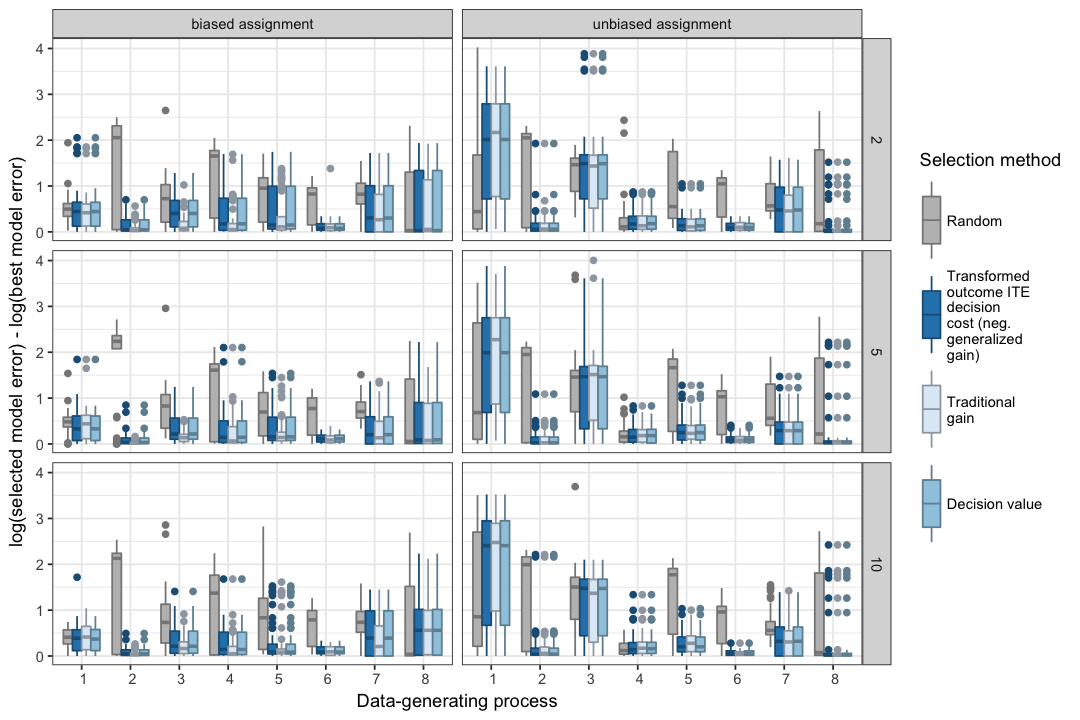

In [91]:
options(repr.plot.width=9, repr.plot.height=6)
full_error_plot(rel_results, method_fills, method_colors, c(method_types$value_methods))

In general, `Random` works decently because all of the models that are being selected from are reasonable.

`trans_mse` also seems to be doing well in terms of value. The decision-based metrics do well here, but again matching seems to hurt relative to weighting (probably because we're using the true .In terms of HTE error, `trans_mse` appears to work the best the most consistently. Matching and descision hurt a bit, trans and mse help. Number of folds doesn't matter that much. 

# Value Methods

These all do the exact same thing, as expected. Gain is a little different than the other two, but only in the biased assignment scenario because its estimating a group-wise propensity there whereas the other two have access to the true propensities.

# Ranking Methods

These all kinda suck. `value_auc` is the only one that consistently does better than random.

# Misc Methods

`random` often beats Rob's method, even with unbiased assignment

# Winner's Bracket

`trans_mse` and `prediction_error` are the winners here.

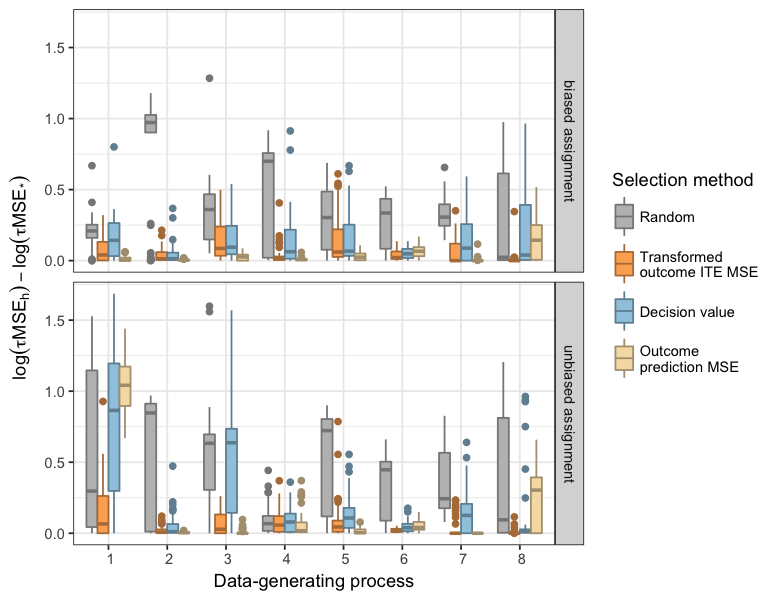

In [130]:
options(repr.plot.width=6.5, repr.plot.height=5)

rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    filter(n_folds==5) %>%
ggplot(aes(x=as.factor(DGP), y=log10(rel_true_hte_error), 
           fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(name="Selection method", values = method_fills, labels = method_renames) + 
    scale_color_manual(name="Selection method", values = method_colors, labels = method_renames) + 
    facet_grid(assignment~.) +
    xlab("Data-generating process") + 
#     ylab("log(selected model error) - log(best model error)") +
    ylab(expression(log(tau * plain(MSE)[h]) - log(tau * plain(MSE)[plain("*")]))) +
    theme_bw() +
    theme(legend.key.height=unit(1, "cm")) + 
    theme(legend.key.width=unit(0.5, "cm"))

Warning message:
In log(rel_true_value): NaNs producedWarning message:
In log(rel_true_value): NaNs producedWarning message:
: Removed 124 rows containing non-finite values (stat_boxplot).

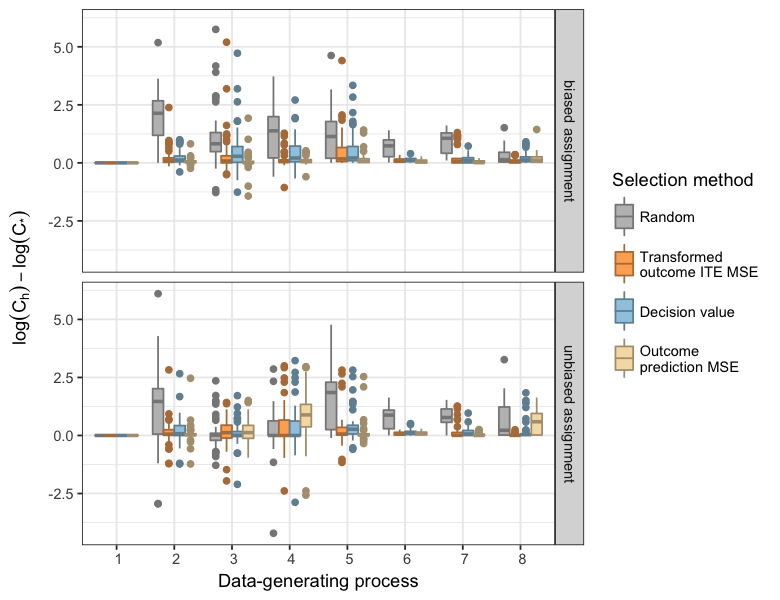

In [131]:
options(repr.plot.width=6.5, repr.plot.height=5)

rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    filter(n_folds==5) %>%
    ggplot(aes(x=as.factor(DGP), y=log(rel_true_value), 
           fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(name="Selection method", values = method_fills, labels = method_renames) + 
    scale_color_manual(name="Selection method", values = method_colors, labels = method_renames) + 
    facet_grid(assignment~.) +
    xlab("Data-generating process") + 
    ylab(expression(log(C[h]) - log(C[plain("*")]))) +
    theme_bw() +
    theme(legend.key.height=unit(1, "cm")) + 
    theme(legend.key.width=unit(0.5, "cm"))